In [44]:
from time import time

from oemof import solph
import tsam.timeseriesaggregation as tsam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def preprocessing(noTypicalPeriods, hoursPerPeriod, data):
    aggregation = tsam.TimeSeriesAggregation(
        data,
        noTypicalPeriods=noTypicalPeriods,
        hoursPerPeriod=hoursPerPeriod,
        clusterMethod='k_means'
    )

    agg_data = aggregation.createTypicalPeriods()

    agg_data.index.names = ['TypicalPeriod', 'TimeStep']
    agg_data.reset_index(inplace=True)

    return aggregation, agg_data

In [46]:
def optimization(agg_data):
    timeindex = pd.date_range('2024-01-01 00:00', freq='h', periods=agg_data.shape[0])
    es = solph.EnergySystem(
        timeindex=timeindex, infer_last_interval=True
    )

    b_gas = solph.Bus("gas bus")
    b_electricity = solph.Bus("electricity bus")
    b_heat = solph.Bus("heat bus")

    source_gas = solph.components.Source(
        "gas source",
        outputs={b_gas: solph.Flow(variable_costs=agg_data["gas_price"] + agg_data["co2_price"])}
    )
    source_electricity = solph.components.Source(
        "electricity source",
        outputs={b_electricity: solph.Flow(variable_costs=agg_data["el_spot_price"])}
    )
    sink_heat = solph.components.Sink(
        "heat demand",
        inputs={b_heat: solph.Flow(fix=agg_data["heat"], nominal_value=1)}
    )

    heat_pump = solph.components.Converter(
        label="heat pump",
        inputs={b_electricity: solph.Flow()},
        outputs={b_heat: solph.Flow(nominal_value=100)},
        conversion_factors={b_heat: 3.5}
    )
    boiler = solph.components.Converter(
        label="gas boiler",
        inputs={b_gas: solph.Flow()},
        outputs={b_heat: solph.Flow(nominal_value=100)},
        conversion_factors={b_heat: 0.9}
    )

    heat_slack = solph.components.Source(
        label="heat slack",
        outputs={b_heat: solph.Flow(variable_costs=1000)}
    )

    storage = solph.components.GenericStorage(
        label="heat storage",
        inputs={b_heat: solph.Flow(nominal_value=50)},
        outputs={b_heat: solph.Flow(nominal_value=50)},
        nominal_storage_capacity=24 * 50,
        initial_storage_level=0.5,
        balanced=True
    )

    es.add(
        b_gas, b_electricity, b_heat,
        source_electricity, source_gas, sink_heat, heat_slack,
        heat_pump, boiler, storage
    )

    model = solph.Model(es)

    _ = model.solve("gurobi")

    results = solph.views.convert_keys_to_strings(model.results())

    return results

In [47]:
def postprocessing(results, agg_data=None, aggregation=None):
    unitdata = pd.DataFrame()
    for vertex, data in results.items():
        if vertex[-1] != 'None':
            unitdata[' to '.join(vertex)] = data['sequences']['flow']
        else:
            unitdata[f'{vertex[0]} storage content'] = data['sequences']['storage_content']

    if agg_data is not None and aggregation is not None:
        unitdata.dropna(inplace=True)
        unitdata.reset_index(inplace=True, drop=True)

        unitdata = pd.concat([unitdata, agg_data[['TypicalPeriod', 'TimeStep']]], axis=1)
        unitdata.set_index(['TypicalPeriod', 'TimeStep'], inplace=True)

        matched_indices = aggregation.indexMatching()

        periods = unitdata.index.get_level_values('TypicalPeriod')
        timesteps = unitdata.index.get_level_values('TimeStep')

        unitdata_flat = pd.DataFrame(unitdata.values, columns=unitdata.columns)
        unitdata_flat['PeriodNum'] = periods
        unitdata_flat['TimeStep'] = timesteps

        desagg_data = matched_indices.reset_index().merge(
            unitdata_flat,
            how='left',
            left_on=['PeriodNum', 'TimeStep'],
            right_on=['PeriodNum', 'TimeStep']
        ).set_index(matched_indices.index)

        desagg_data = desagg_data.drop(columns=['Date', 'PeriodNum', 'TimeStep'])

        return desagg_data
    
    else:
        return unitdata

In [48]:
def calc_key_params(desagg_data, ts_in):
    el_cost = (desagg_data['electricity source to electricity bus'] * ts_in['el_spot_price']).sum()
    gas_cost = (desagg_data['gas source to gas bus'] * (
        ts_in['gas_price'] + ts_in['co2_price']
    )).sum()
    slack_cost = (desagg_data['heat slack to heat bus'] * 1000).sum()

    opex_total = el_cost + gas_cost + slack_cost

    heat_prod_shares = (
        desagg_data[['heat pump to heat bus', 'gas boiler to heat bus', 'heat slack to heat bus']].sum()
        / desagg_data[['heat pump to heat bus', 'gas boiler to heat bus', 'heat slack to heat bus']].sum().sum()
        )
    heat_prod_shares

    heat_prod_total = desagg_data['heat bus to heat demand'].sum()

    return opex_total, heat_prod_shares, heat_prod_total

In [49]:
def test_agg_performance(noTypicalPeriods, hoursPerPeriod):
    ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
    ts_in = ts_in.drop(columns="ef_om")
    missing_hours = ts_in.shape[0] % hoursPerPeriod
    if missing_hours > 0:
        ts_in = ts_in.iloc[:-missing_hours, :]

    print('Perfomance Clustering & Preprocessing:')
    %timeit aggregation, agg_data = preprocessing(noTypicalPeriods=noTypicalPeriods, hoursPerPeriod=hoursPerPeriod, data=ts_in)
    print('Perfomance Optimization:')
    %timeit results = optimization(agg_data=agg_data)
    print('Perfomance Desaggregation:')
    %timeit desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)

In [50]:
def run_optimization_timed(noTypicalPeriods, hoursPerPeriod):
    ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
    ts_in = ts_in.drop(columns="ef_om")
    missing_hours = ts_in.shape[0] % hoursPerPeriod
    if missing_hours > 0:
        ts_in = ts_in.iloc[:-missing_hours, :]

    starttime = time()
    aggregation, agg_data = preprocessing(noTypicalPeriods=noTypicalPeriods, hoursPerPeriod=hoursPerPeriod, data=ts_in)
    aggregation_time = time() - starttime

    starttime = time()
    results = optimization(agg_data=agg_data)
    optimization_time = time() - starttime

    starttime = time()
    desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
    disaggregation_time = time() - starttime

    opex_total, heat_prod_shares, heat_prod_total = calc_key_params(desagg_data=desagg_data, ts_in=ts_in)

    return aggregation_time, optimization_time, disaggregation_time, desagg_data, opex_total, heat_prod_shares, heat_prod_total

In [65]:
ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
ts_in = ts_in.drop(columns="ef_om")

results = optimization(agg_data=ts_in)
unitdata = postprocessing(results)
opex_total_base, heat_prod_shares_base, heat_prod_total_base = calc_key_params(unitdata, ts_in)

heat_prod_shares_base

c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\oemof\solph\_models.py:497: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if self.flows[o, i].fix[self.TIMESTEPS.at(1)] is not None:
c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\oemof\solph\_models.py:500: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.flows[o, i].fix[t]
c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\oemof\solph\flows\_simple_flow_block.py:464: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

heat pump to heat bus     0.637745
gas boiler to heat bus    0.323624
heat slack to heat bus    0.038631
dtype: float64

In [67]:
heat_prod_total_base * 1000 * 0.0386

45282661.02540624

In [52]:
noTypicalPeriods = 10
hoursPerPeriod = 168

ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
ts_in = ts_in.drop(columns="ef_om")
missing_hours = ts_in.shape[0] % hoursPerPeriod
if missing_hours > 0:
    ts_in = ts_in.iloc[:-missing_hours, :]
ts_in.shape

(8736, 4)

In [53]:
aggregation, agg_data = preprocessing(noTypicalPeriods=noTypicalPeriods, hoursPerPeriod=hoursPerPeriod, data=ts_in)

In [54]:
agg_data

,TypicalPeriod,TimeStep,co2_price,el_spot_price,gas_price,heat
0,0,0,25.05,30.814,14.2416,59.506
1,0,1,25.05,29.672,14.2416,59.420
2,0,2,25.05,29.136,14.2416,63.334
3,0,3,25.05,29.358,14.2416,65.866
4,0,4,25.05,31.348,14.2416,72.232
...,...,...,...,...,...,...
1675,9,163,20.84,42.080,22.0700,269.710
1676,9,164,20.84,39.420,22.0700,232.460
1677,9,165,20.84,38.750,22.0700,226.930
1678,9,166,20.84,38.520,22.0700,223.360


In [55]:
results = optimization(agg_data=agg_data)
results

{('electricity bus',
  'heat pump'): {'scalars': Series([], Name: 2024-01-01 00:00:00, dtype: float64), 'sequences': variable_name             flow
  2024-01-01 00:00:00  28.571429
  2024-01-01 01:00:00  28.571429
  2024-01-01 02:00:00  28.571429
  2024-01-01 03:00:00  28.571429
  2024-01-01 04:00:00  28.571429
  ...                        ...
  2024-03-10 20:00:00  28.571429
  2024-03-10 21:00:00  28.571429
  2024-03-10 22:00:00  28.571429
  2024-03-10 23:00:00  28.571429
  2024-03-11 00:00:00        NaN
  
  [1681 rows x 1 columns]},
 ('electricity source',
  'electricity bus'): {'scalars': Series([], Name: 2024-01-01 00:00:00, dtype: float64), 'sequences': variable_name             flow
  2024-01-01 00:00:00  28.571429
  2024-01-01 01:00:00  28.571429
  2024-01-01 02:00:00  28.571429
  2024-01-01 03:00:00  28.571429
  2024-01-01 04:00:00  28.571429
  ...                        ...
  2024-03-10 20:00:00  28.571429
  2024-03-10 21:00:00  28.571429
  2024-03-10 22:00:00  28.571429
  20

In [56]:
# desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
desagg_data

,electricity bus to heat pump,electricity source to electricity bus,gas boiler to heat bus,gas bus to gas boiler,gas source to gas bus,heat bus to heat demand,heat bus to heat storage,heat pump to heat bus,heat slack to heat bus,heat storage storage content,heat storage to heat bus
Date,,,,,,,,,,,
2019-01-01 00:00:00,28.571429,28.571429,62.2350,69.150000,69.150000,179.8925,0.0000,100.0,0.000,1200.0000,17.6575
2019-01-01 01:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,182.3425,17.6575,100.0,0.000,1182.3425,0.0000
2019-01-01 02:00:00,28.571429,28.571429,89.3175,99.241667,99.241667,189.9100,0.0000,100.0,0.000,1200.0000,0.5925
2019-01-01 03:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,199.4075,50.0000,100.0,0.000,1199.4075,49.4075
2019-01-01 04:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,212.0450,0.0000,100.0,12.045,1200.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,199.2650,0.7350,100.0,0.000,1142.6090,0.0000
2019-12-30 20:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,186.8980,13.1020,100.0,0.000,1143.3440,0.0000
2019-12-30 21:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,174.5730,50.0000,100.0,0.000,1156.4460,24.5730


Text(0, 0.5, 'Stündliche Wärmeproduktion in MW')

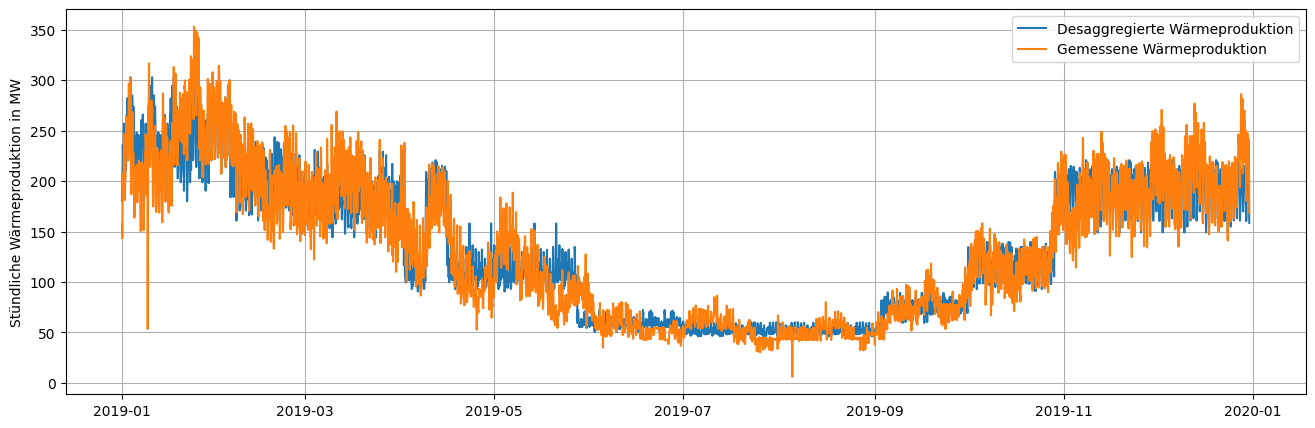

In [57]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(desagg_data['heat bus to heat demand'], label='Desaggregierte Wärmeproduktion')
ax.plot(ts_in['heat'], label='Gemessene Wärmeproduktion')

ax.legend()
ax.grid()
ax.set_ylabel('Stündliche Wärmeproduktion in MW')

Text(0, 0.5, 'Wärmespeicherfüllstand in MWh')

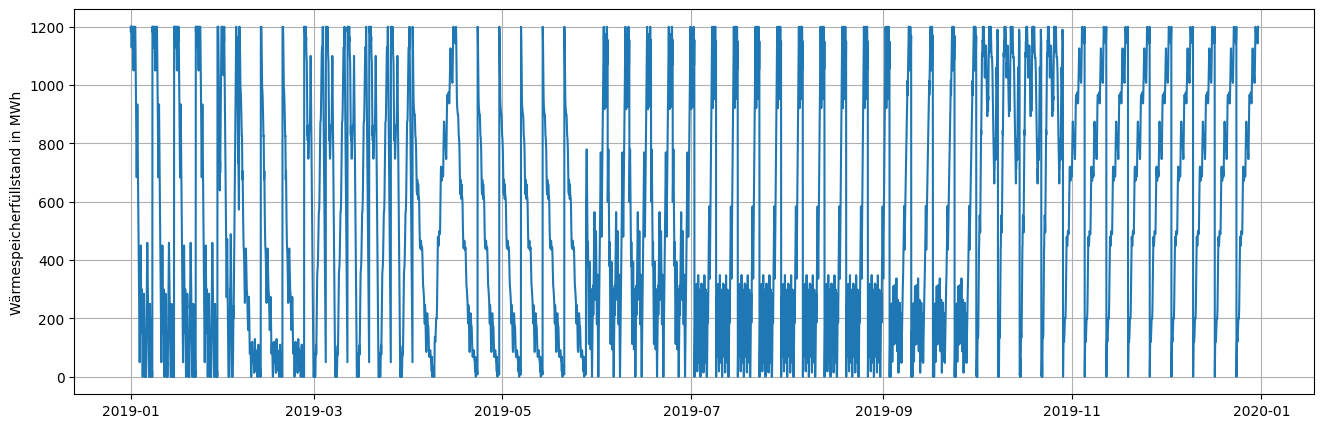

In [58]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(desagg_data['heat storage storage content'])

ax.grid()
ax.set_ylabel('Wärmespeicherfüllstand in MWh')

In [59]:
test_agg_performance(noTypicalPeriods=10, hoursPerPeriod=168)

Perfomance Clustering & Preprocessing:
1.03 s ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Perfomance Optimization:
1.3 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Perfomance Desaggregation:
112 ms ± 8.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
nr_periods = list(range(1, 21))
hours_per_period = [24, 3*24, 7*24, 14*24]

multiindex = pd.MultiIndex.from_product([nr_periods, hours_per_period])
perf = pd.DataFrame(index=multiindex)
keyparams = pd.DataFrame(index=multiindex)

for nr_period in nr_periods:
    for hour_pp in hours_per_period:
        aggregation_time, optimization_time, disaggregation_time, desagg_data, opex_total, heat_prod_shares, heat_prod_total = run_optimization_timed(noTypicalPeriods=nr_period, hoursPerPeriod=hour_pp)
        perf.loc[(nr_period, hour_pp), 'aggregation_time'] = aggregation_time
        perf.loc[(nr_period, hour_pp), 'optimization_time'] = optimization_time
        perf.loc[(nr_period, hour_pp), 'disaggregation_time'] = disaggregation_time
        keyparams.loc[(nr_period, hour_pp), 'opex_total'] = opex_total
        keyparams.loc[(nr_period, hour_pp), 'hp_share'] = heat_prod_shares['heat pump to heat bus']
        keyparams.loc[(nr_period, hour_pp), 'gb_share'] = heat_prod_shares['gas boiler to heat bus']
        keyparams.loc[(nr_period, hour_pp), 'slack_share'] = heat_prod_shares['heat slack to heat bus']
        keyparams.loc[(nr_period, hour_pp), 'heat_prod_total'] = heat_prod_total

perf['total_time'] = perf['aggregation_time'] + perf['optimization_time'] + perf['disaggregation_time']

c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['co2_price', 'el_spot_price']
  warnings.warn(
c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['co2_price', 'el_spot_price']
  warnings.warn(
c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(
c:\Users\Malte\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong...

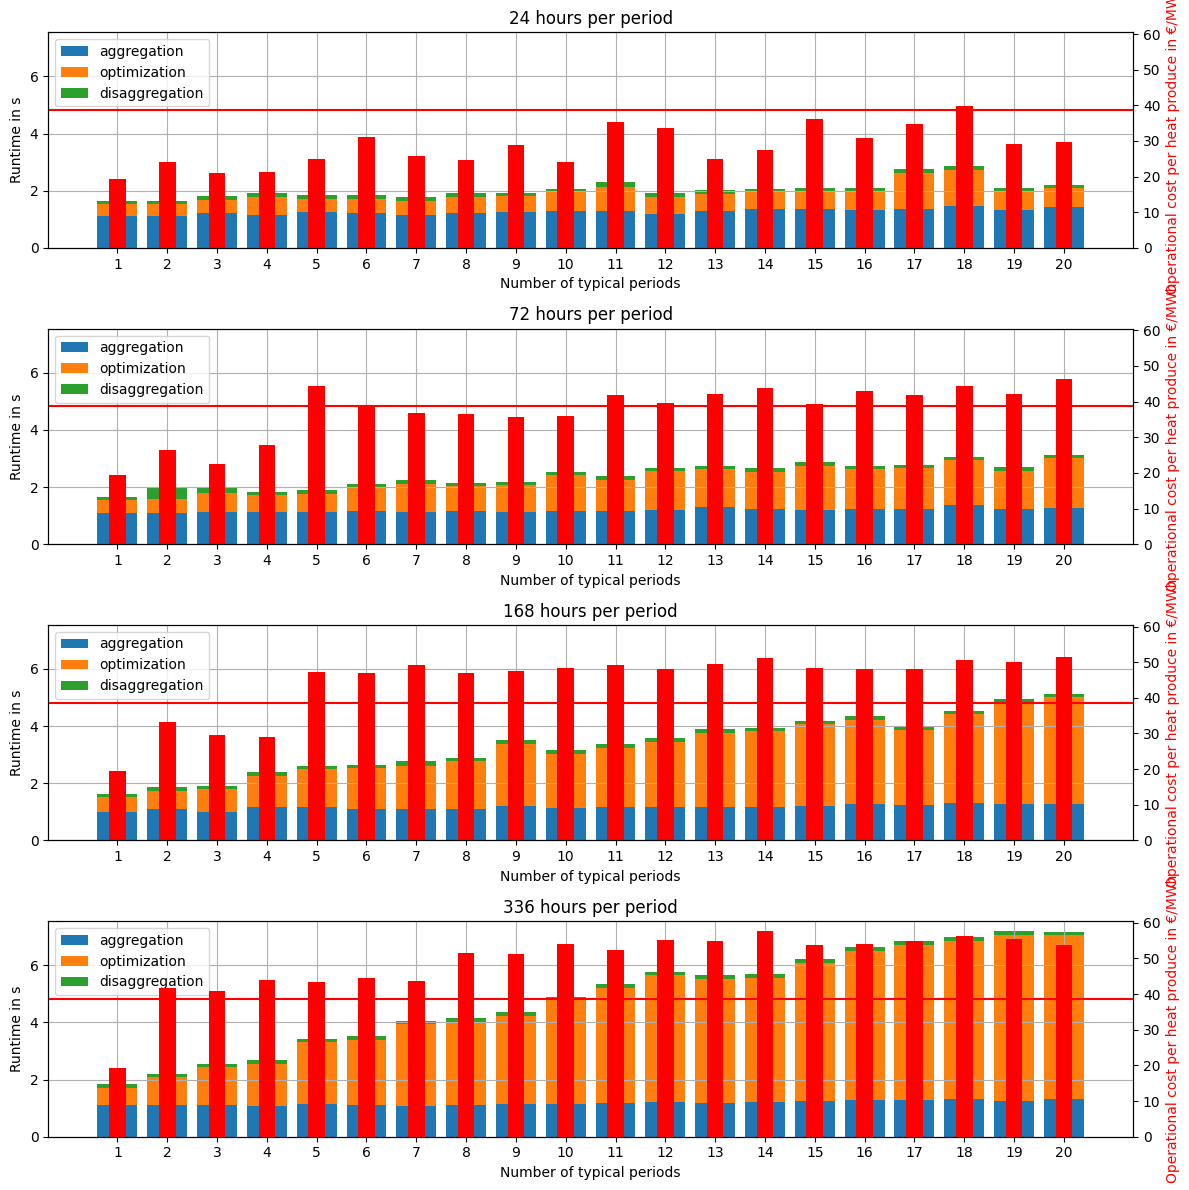

In [63]:
nr_axs = len(hours_per_period)
fig, ax = plt.subplots(nr_axs, 1, figsize=(12, 3*nr_axs))

for i, hour_pp in enumerate(hours_per_period):
    ax[i].bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'aggregation_time'], label='aggregation')
    ax[i].bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'optimization_time'], label='optimization', bottom=perf.loc[(nr_periods, hour_pp), 'aggregation_time'])
    ax[i].bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'disaggregation_time'], label='disaggregation', bottom=perf.loc[(nr_periods, hour_pp), 'aggregation_time']+perf.loc[(nr_periods, hour_pp), 'optimization_time'])
    
    ax2 = ax[i].twinx()
    ax2.bar(
        nr_periods, keyparams.loc[(nr_periods, hour_pp), 'opex_total']
        /keyparams.loc[(nr_periods, hour_pp), 'heat_prod_total'], 
        width=1/3, label='opex_total', color='red'
        )
    ax2.set_ylim(0, 1.05*(keyparams['opex_total']/keyparams['heat_prod_total']).max())
    ax2.set_ylabel('Operational cost per heat produce in €/MWh', color='red')
    ax2.axhline(opex_total_base/heat_prod_total_base, color='red')

    ax[i].grid()
    ax[i].set_ylim(0, 1.05*perf['total_time'].max())
    ax[i].set_xticks(nr_periods, labels=nr_periods)
    ax[i].set_title(f'{hour_pp} hours per period')
    ax[i].set_xlabel('Number of typical periods')
    ax[i].set_ylabel('Runtime in s')
    ax[i].legend(loc='upper left')

plt.tight_layout()

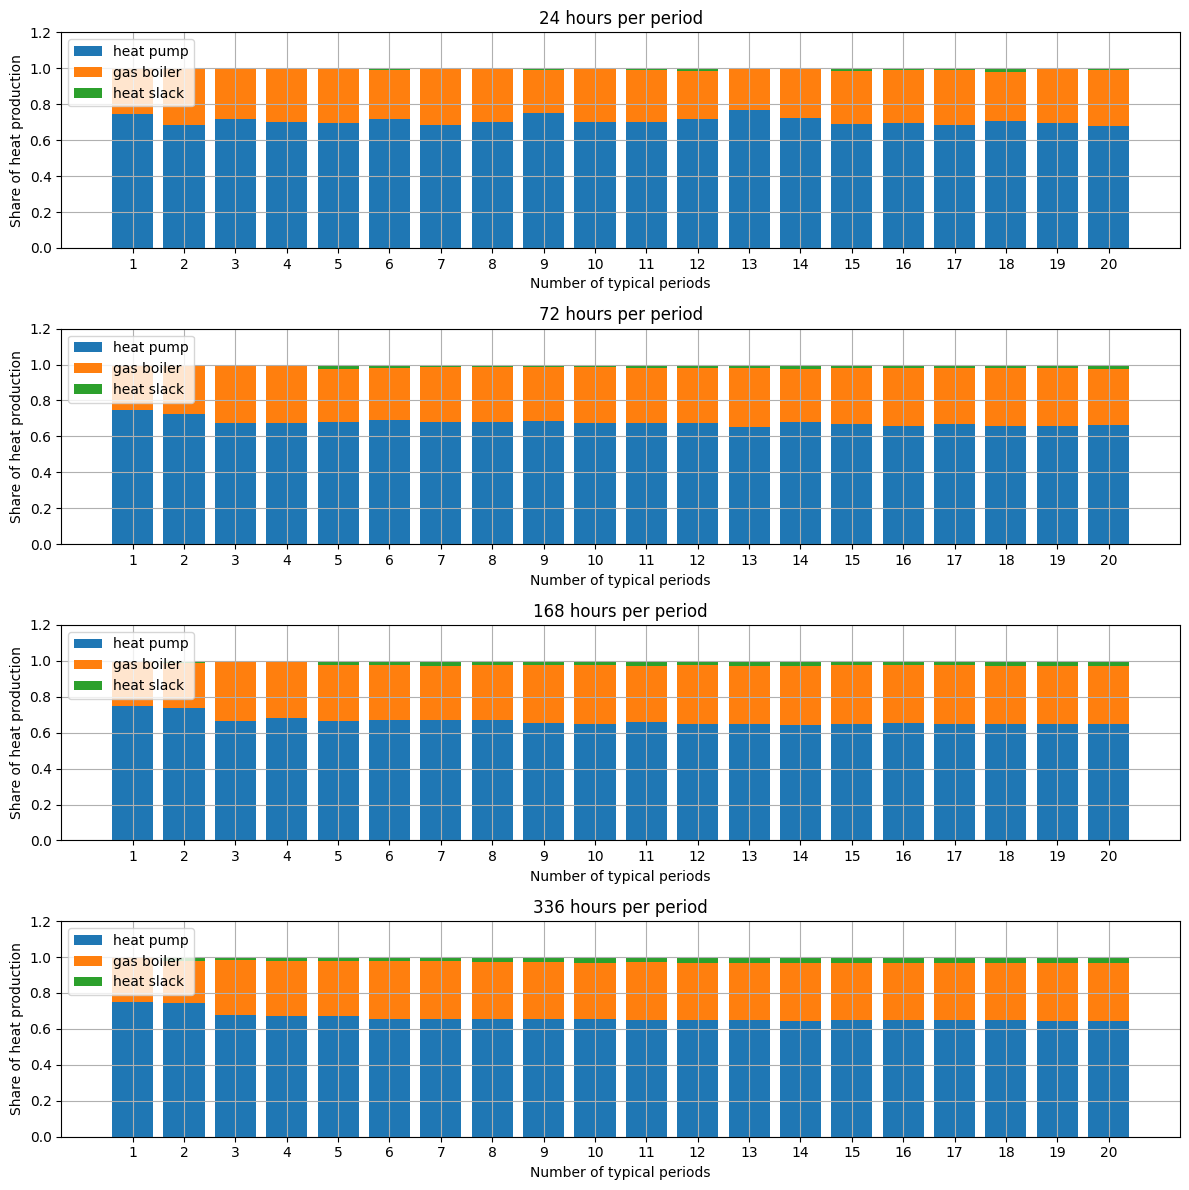

In [64]:
nr_axs = len(hours_per_period)
fig, ax = plt.subplots(nr_axs, 1, figsize=(12, 3*nr_axs))

for i, hour_pp in enumerate(hours_per_period):
    ax[i].bar(nr_periods, keyparams.loc[(nr_periods, hour_pp), 'hp_share'], label='heat pump')
    ax[i].bar(nr_periods, keyparams.loc[(nr_periods, hour_pp), 'gb_share'], label='gas boiler', bottom=keyparams.loc[(nr_periods, hour_pp), 'hp_share'])
    ax[i].bar(nr_periods, keyparams.loc[(nr_periods, hour_pp), 'slack_share'], label='heat slack', bottom=keyparams.loc[(nr_periods, hour_pp), 'hp_share']+keyparams.loc[(nr_periods, hour_pp), 'gb_share'])

    ax[i].grid()
    ax[i].set_ylim(0, 1.2)
    ax[i].set_xticks(nr_periods, labels=nr_periods)
    ax[i].set_title(f'{hour_pp} hours per period')
    ax[i].set_xlabel('Number of typical periods')
    ax[i].set_ylabel('Share of heat production')
    ax[i].legend(loc='upper left')

plt.tight_layout()